# Quantum Computing - Quantum Machine Learning

### 0 - Setup

In [1]:
import qiskit as q
from qiskit_machine_learning import kernels, algorithms

from sklearn import model_selection, svm, metrics, preprocessing
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

### 1 - Classification

###### Data

In [2]:
dtf = pd.read_csv('https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/machine_learning/data_titanic.csv')
dtf = dtf[["Fare","Age","Survived"]].rename(columns={"Survived":"Y"}).dropna()
dtf = dtf.sample(frac=0.2, random_state=123).reset_index(drop=True)
dtf

,Fare,Age,Y
0,23.0000,18.0,1
1,26.5500,60.0,0
2,8.6833,31.0,1
3,7.2250,15.0,1
4,108.9000,18.0,0
...,...,...,...
138,7.8958,28.0,0
139,11.5000,21.0,0
140,110.8833,49.0,0
141,7.7750,74.0,0


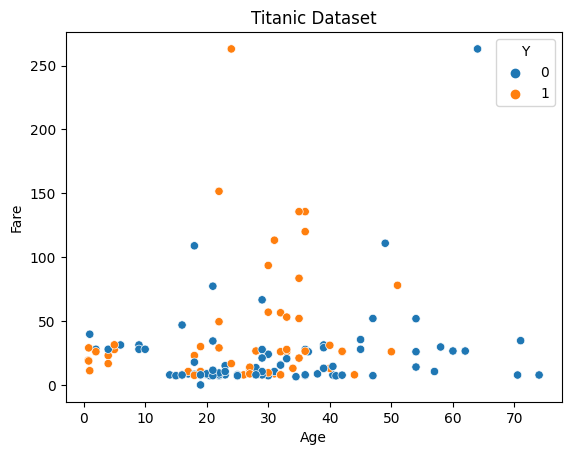

In [3]:
sns.scatterplot(data=dtf, x='Age', y='Fare', hue='Y').set_title('Titanic Dataset')
plt.show()

###### Preprocessing

In [4]:
# partitioning
X_train, X_test, y_train, y_test = model_selection.train_test_split(dtf[["Fare","Age"]], dtf["Y"], 
                                                                    train_size=0.7, shuffle=False)

In [5]:
# scale
scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

###### Classical Model

In [6]:
# train
model = svm.SVC()
model.fit(X_train, y_train)

# test
preds = model.predict(X_test)

# evaluate
print(" accurcay:", round(metrics.accuracy_score(y_test, preds), 2),
      "\n precision:", round(metrics.precision_score(y_test, preds), 2),
      "\n recall:", round(metrics.recall_score(y_test, preds), 2))

 accurcay: 0.63 
 precision: 0.2 
 recall: 0.08


###### Quantum Model

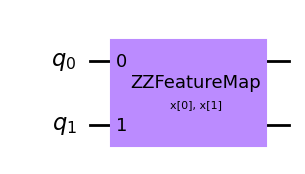

In [7]:
# create kernel
circuit = q.circuit.library.ZZFeatureMap(feature_dimension=2, entanglement="linear")  #<-- Pauli-Z circuit
backend = q.utils.QuantumInstance(q.BasicAer.get_backend('qasm_simulator'), shots=1024)
kernel = kernels.QuantumKernel(feature_map=circuit, quantum_instance=backend)

# plot
circuit.draw(output="mpl")

In [8]:
# train
qmodel = algorithms.QSVC(quantum_kernel=kernel)
qmodel.fit(X_train, y_train)

# test
preds = qmodel.predict(X_test)

# evaluate
print(" accurcay:", round(metrics.accuracy_score(y_test, preds), 2),
      "\n precision:", round(metrics.precision_score(y_test, preds), 2),
      "\n recall:", round(metrics.recall_score(y_test, preds), 2))

 accurcay: 0.51 
 precision: 0.25 
 recall: 0.31


### 2 - Regression

###### Data

In [9]:
dtf = pd.read_csv("https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/machine_learning/data_houses.csv")
dtf = dtf[["OverallQual","GrLivArea","SalePrice"]].rename(columns={"SalePrice":"Y"})
dtf = dtf.sample(frac=0.1, random_state=123).reset_index(drop=True)
dtf

,OverallQual,GrLivArea,Y
0,7,2035,222500
1,4,1774,87000
2,7,1708,130000
3,7,2097,274300
4,5,1558,140000
...,...,...,...
141,7,1950,239000
142,6,1953,240000
143,5,894,142500
144,6,1640,224000


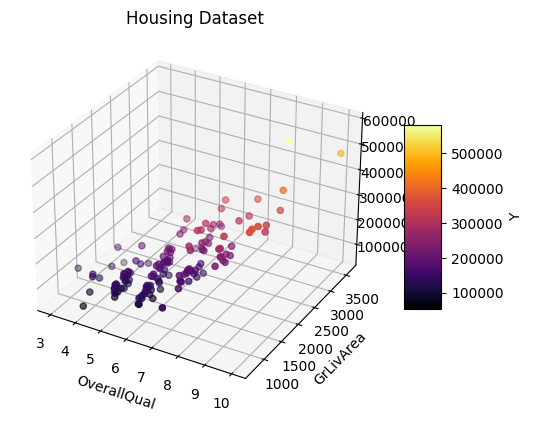

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
plot3d = ax.scatter(xs=dtf["OverallQual"], ys=dtf["GrLivArea"], zs=dtf["Y"], c=dtf["Y"], cmap='inferno')
ax.set(xlabel="OverallQual", ylabel="GrLivArea", zlabel="Y", title="Housing Dataset")
fig.colorbar(plot3d, shrink=0.5, aspect=5, label="Y")
plt.show()

###### Preprocessing

In [11]:
# partitioning
X_train, X_test, y_train, y_test = model_selection.train_test_split(dtf[["OverallQual","GrLivArea"]], dtf["Y"], 
                                                                    train_size=0.7, shuffle=False)

In [12]:
# scale
scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = preprocessing.MinMaxScaler(feature_range=(0,1))
y_train = scaler_y.fit_transform(y_train.values.reshape(-1,1))

###### Classical Model

In [13]:
# train
model = svm.SVR()
model.fit(X_train, y_train)

# test
preds = scaler_y.inverse_transform( model.predict(X_test).reshape(-1,1) )

# evaluate
print(" r2:", round(metrics.r2_score(y_test, preds), 2),
      "\n mape:", round(metrics.mean_absolute_percentage_error(y_test, preds), 2),
      "\n mae:", "{:,.0f}".format(metrics.mean_absolute_error(y_test, preds)))

 r2: 0.65 
 mape: 0.2 
 mae: 38,970


###### Quantum Model

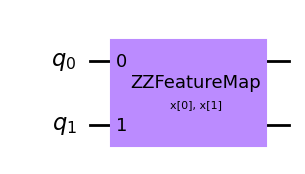

In [14]:
# create kernel
circuit = q.circuit.library.ZZFeatureMap(feature_dimension=2, entanglement="linear")  #<-- Pauli-Z circuit
backend = q.utils.QuantumInstance(q.BasicAer.get_backend('qasm_simulator'), shots=1024)
kernel = kernels.QuantumKernel(feature_map=circuit, quantum_instance=backend)

# plot
circuit.draw(output="mpl")

In [15]:
# train
qmodel = algorithms.QSVR(quantum_kernel=kernel)
qmodel.fit(X_train, y_train)

# test
preds = scaler_y.inverse_transform( qmodel.predict(X_test).reshape(-1,1) )

# evaluate
print(" r2:", round(metrics.r2_score(y_test, preds), 2),
      "\n mape:", round(metrics.mean_absolute_percentage_error(y_test, preds), 2),
      "\n mae:", "{:,.0f}".format(metrics.mean_absolute_error(y_test, preds)))

 r2: 0.68 
 mape: 0.2 
 mae: 37,898
